# Cora dataset
Citation network dataset created by Andrew McCallum for research purposes. It is widely used as a benchmark dataset in the Machine Learning community.

## Dataset Description:

1. 2708 scientific publications represented as nodes 
2. 5429 citation network links (If paper A cites paper B, there will be a directed edge from A to B in the graph) indicating it is a directed edge graph
3. 1433 unique words in the vocabulary. Academic papers each represented as a bag-of-words vector after stemming and removing stopwords. The vocabulary size is reduced by removing words with document frequency less than 10. The words in the papers are represented in a binary format, indicating whether each word in the vocabulary is present (1) or absent (0) in the paper. 


### Bag-of-words vector:
A bag-of-words (BoW) vector is a simple and popular way to represent text data in natural language processing (NLP) and information retrieval tasks. It is a numerical representation that converts a piece of text (e.g., a sentence, a document, or a corpus) into a fixed-length vector.
Let's consider an example: Suppose we have a corpus of 3 documents as below:

Document 1: "Machine learning is fascinating."

Document 2: "Natural language processing is challenging."

Document 3: "Machine learning and natural language processing are exciting fields."

Vocabulary formed from these documents is : {"Machine", "learning", "is", "fascinating", "Natural", "language", "processing", "challenging", "and", "are", "exciting", "fields"}

The bag-of-words vectors for the three documents would be:

Document 1: [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]

Document 2: [0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]

Document 3: [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]



The Cora dataset contains seven classes to which the papers are classified: 
1. Neural Networks
2. Probabilistic Methods
3. Genetic Algorithms        
4. Theory                    
5. Case Based                
6. Reinforcement Learning    
7. Rule Learning

All papers in the corpus cite or are cited by at least one other paper, forming a citation graph.

### The .content file:

This file contains descriptions of the papers in the following format:

                            <paper_id> <word_attributes>+ <class_label>
                            
The first entry in each line is a unique string ID representing the paper. The subsequent binary values indicate the presence or absence of each word in the vocabulary in the paper. The last entry in the line contains the class label of the paper, indicating which category it belongs to out of the defined 7 classes.

### The .cites file:

This file contains the citation graph of the corpus, indicating the relationships between papers. Each line describes a link in the following format: 

                            <ID of cited paper> <ID of citing paper>
                            
The first entry is the ID of the paper being cited, and the second entry is the ID of the paper that contains the citation. The direction of the link is from right to left, meaning that "paper2->paper1" represents a citation from paper2 to paper1implying a Directed graph.
It is not necessary that there is a mutual citation link between two papers resulting in Undirected graph.

## Planetoid Dataset

The Planetoid dataset containing three citation network datasets Cora, Citeseer, PubMed is a popular benchmark dataset for graph based semi-supervised learning tasks. It serves as a standard benchmark for testing new graph neural network architectures and training techniques on citation networks. Researchers use this dataset to compare the performance of different methods and to demonstrate advancements in graph-based semi-supervised learning algorithms.

In [1]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import torch
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils.convert import to_networkx
import networkx as nx
from torch.optim.lr_scheduler import OneCycleLR

import urllib.request
import tarfile

In [2]:
# Load the dataset (Planetoid data format)

# URL of the "cora.tgz" file
coraTarFile = 'https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz'

# Local directory to save the downloaded file
save_dir = 'D:\MS\Michigan\Courses\Summer project\Dataset'  

# Create the directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Download the file and save it to the local directory
local_file_path, _ = urllib.request.urlretrieve(coraTarFile, filename=os.path.join(save_dir, 'cora.tgz'))

# Extract the contents of the downloaded file
with tarfile.open(local_file_path, "r:gz") as zip_file:
    zip_file.extractall(path=save_dir)

# After extraction, the contents should be available in the "data" directory (data_dir)
data_dir = os.path.join(save_dir, "cora")


In [3]:
# Now load "cora.cites" and "cora.content" files
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)

papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"),
    sep="\t",
    header=None,
    names=["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"],
)

# Data Exploration

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


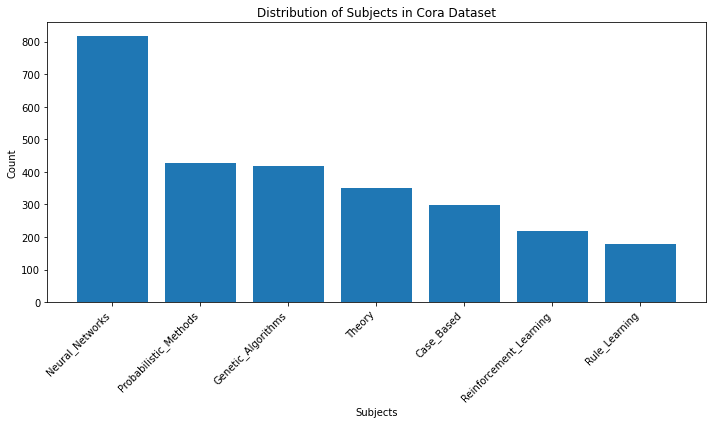

In [4]:
# Get the value counts of subjects
subject_counts = papers['subject'].value_counts()
print(papers.subject.value_counts())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(subject_counts.index, subject_counts.values)
plt.xlabel('Subjects')
plt.ylabel('Count')
plt.title('Distribution of Subjects in Cora Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
# Data pre-processing
# Now create the Planetoid dataset with the path directory
# Planetoid dataset here contains only one graph
dataset = Planetoid(root=data_dir, name='cora', transform=T.NormalizeFeatures())
data = dataset[0]  # Accesses the first (and only) graph in the dataset

# Now you can access the attributes of the dataset, such as test_mask
print(len(data.train_mask))
print(len(data.test_mask))  # number of nodes in the graph that are used for testing

2708
2708


In [6]:
# Unique labels or classification of papers
print("Label of unique papers ", np.unique(data.y))

Label of unique papers  [0 1 2 3 4 5 6]


In [7]:
print(dataset)
print("Number of graphs:\t\t",len(dataset))
print("Number of classes:\t\t",dataset.num_classes)
print("Unique Labels of classes:\t",np.unique(data.y))
print("Number of node features:\t",data.num_node_features)
print("Number of edge features:\t",data.num_edge_features)
print("X shape: ", data.x.shape)
print("Edge shape: ", data.edge_index.shape)
print("Y shape: ", data.y.shape)

cora()
Number of graphs:		 1
Number of classes:		 7
Unique Labels of classes:	 [0 1 2 3 4 5 6]
Number of node features:	 1433
Number of edge features:	 0
X shape:  torch.Size([2708, 1433])
Edge shape:  torch.Size([2, 10556])
Y shape:  torch.Size([2708])


In [8]:
# Convert the edge_index tensor to a NumPy array
edge_index_np = data.edge_index.numpy()

# Transpose the array to separate source and target nodes
edges = edge_index_np.transpose()

# Find unique edges
unique_edges = np.unique(edges, axis=0)

# Compare the number of unique edges with the total number of edges
num_unique_edges = unique_edges.shape[0]
num_total_edges = edge_index_np.shape[1]  # The total number of edges

print("Number of unique edges:", num_unique_edges)
print("Number of total edges:", num_total_edges)

# Check if there are duplicate edges
if num_unique_edges == num_total_edges:
    print("No duplicate edges.")
else:
    print("Duplicate edges found.")


Number of unique edges: 10556
Number of total edges: 10556
No duplicate edges.


Each citation link is saved as an undirected edge in both directions, which approximately doubles the number of edges and duplicate edges are removed.
Many graph-based algorithms, including GCNs, work with undirected graphs. By treating the citation links as undirected edges, we can apply standard GCN implementations to the Cora dataset without any modifications.

## Train-Validation-Test data

The process of choosing nodes for the training, testing, and validation sets in the Cora dataset follows a fixed split and is not random. The dataset comes pre-divided into the training, testing, and validation sets, which is commonly used to evaluate graph-based machine learning models consistently across different experiments.

In the Cora dataset, the node split is as follows:

Training nodes: These are the nodes used to train the graph-based machine learning model. They are the nodes with labeled ground-truth categories (i.e., their class labels are known). The model learns from these nodes during the training process.

Validation nodes: These nodes are typically used for model selection and hyperparameter tuning. During training, the model's performance on the validation nodes is monitored, and the hyperparameters or model architectures that perform the best on the validation set are selected.

Test nodes: These nodes are used to evaluate the model's performance and generalization ability after it has been trained. The model has not seen these nodes during training, and their class labels are withheld during training. After the model is trained, it is tested on these nodes to see how well it can classify them based on the patterns learned during training.

In [9]:
# check training nodes
print("Number of nodes to train on: ", data.train_mask.sum().item())

# check test nodes
print("Number of nodes to test on: ", data.test_mask.sum().item())

# check validation nodes
print("Number of nodes to validate on: ", data.val_mask.sum().item())

Number of nodes to train on:  140
Number of nodes to test on:  1000
Number of nodes to validate on:  500


In [19]:
print(data)
print(data.y[0])
print(data.x[0])

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
tensor(3)
tensor([0., 0., 0.,  ..., 0., 0., 0.])


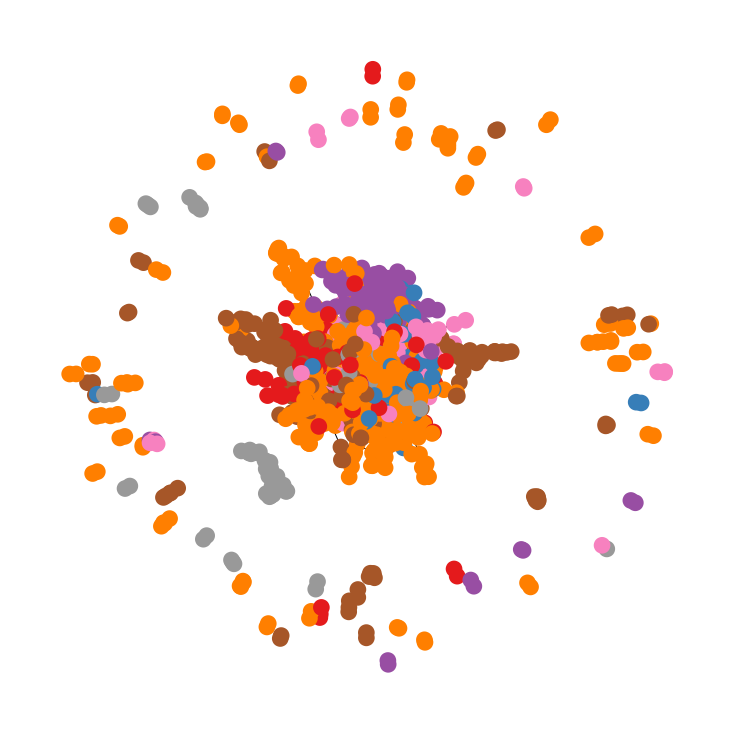

In [33]:
# Subset of Cora dataset with first 100 nodes and edges for visualization
plt.figure(figsize=(10, 10))
cora = torch_geometric.data.Data(x=data.x[:100], edge_index=data.edge_index[:100])

# The graph is treated as undirected, even though the original Cora dataset represents a directed graph
g = torch_geometric.utils.to_networkx(cora, to_undirected=True)
coragraph = to_networkx(cora)
node_labels = data.y[list(coragraph.nodes)].numpy()

# Draw the graph with node labels
nx.draw(g, cmap=plt.get_cmap('Set1'),node_color = node_labels,node_size=75,linewidths=8)

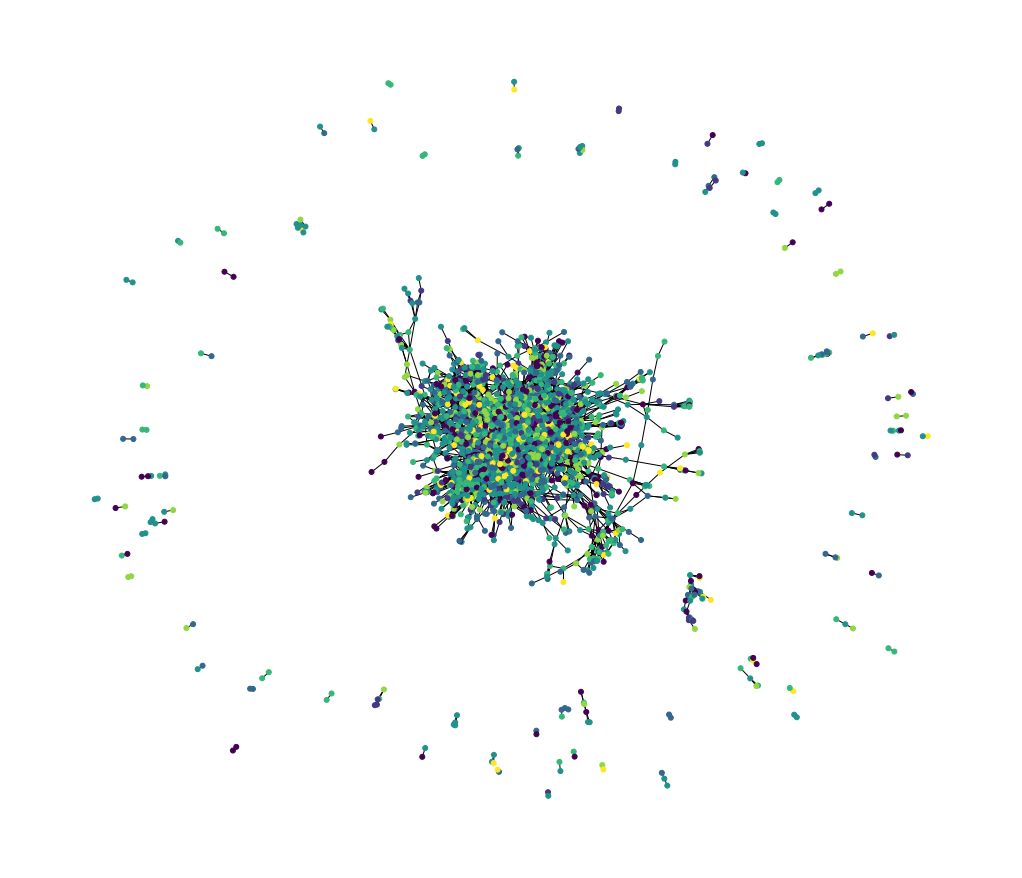

In [34]:
# Visualizing the entire Cora dataset
coragraph = to_networkx(data)

node_labels = data.y[list(coragraph.nodes)].numpy()

plt.figure(1,figsize=(14,12)) 
nx.draw_spring(g, node_size=25, node_color=node_labels)

In [35]:
# Defining funtion to Compute accuracy
def compute_accuracy(pred_y, y):
    return (pred_y == y).sum()

# Defining the Model

The GCNConv class is responsible for defining the graph convolutional layers. When these layers are created, the weights of each layer are automatically initialized according to the initialization strategy specified by PyTorch for each layer type.
PyTorch initializes the weights by default using a method that takes into account the number of input and output units to provide a proper initialization for the given layer architecture. This ensures that the model starts with reasonable initial weights, which can help the training process converge more efficiently.

In [36]:
# Defining the layers of GCN
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        # x: Node feature matrix 
        # edge_index: Graph connectivity matrix 

        x, edge_index = data.x, data.edge_index

# The node feature matrix x is passed through the first Graph Convolutional layer (conv1) along with the 
# graph connectivity matrix edge_index.
        x = self.conv1(x, edge_index)
    
#The output of the first convolutional layer is passed through a ReLU activation function, which introduces non-linearity
# to the model
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
# The dropout-processed output from the previous layer is passed through the second Graph Convolutional layer (conv2) along
# with the graph connectivity matrix edge_index        
        x = self.conv2(x, edge_index)
    
# The final output from the second convolutional layer is passed through a log-softmax function. 
# This operation converts the raw model output into a probability distribution over the classes.
        return F.log_softmax(x, dim=1)

Dropout is a regularization technique that randomly sets a fraction of the node features to zero during training to prevent overfitting.

In [37]:
print("Graph Convolutional Network (GCN):")
GCN()

Graph Convolutional Network (GCN):


GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

# Model Training

Adam Optimizer:
Popular optimization algorithm for training neural networks. It optimizes the model's parameters during training to minimize the loss function.

In [38]:
# Define the model and optimizer
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [39]:
# Define the learning rate scheduler
total_steps = len(data.train_mask) * 200  # Total number of steps for 200 epochs
scheduler = OneCycleLR(optimizer, max_lr=0.1, total_steps=total_steps)

# Train the model
model.train()
losses = []
accuracies = []
validation_accuracies = []
best_val_loss = float('inf')
patience = 10  # Number of epochs to wait if the validation loss does not improve
wait = 0

for epoch in range(200):
    optimizer.zero_grad()
    
# Forward pass through the model using the input data 'data'    
    out = model(data)
    
# Compute the negative log-likelihood loss using the output predictions (out) and the ground truth labels (data.y) 
# for the training nodes only (data.train_mask)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    correct = compute_accuracy(out.argmax(dim=1)[data.train_mask], data.y[data.train_mask])
    acc = int(correct) / int(data.train_mask.sum())
    losses.append(loss.item())
    accuracies.append(acc)
    
# Backpropagate the gradients of the loss with respect to the model parameters. This computes the gradients 
# required to update the model weights during optimization.
    loss.backward()
        
# Perform a parameter update using the computed gradients    
    optimizer.step()
    scheduler.step()
    
# Print training and validation accuracy for every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}, Loss: {loss.item():.4f}, Training Acc: {acc:.4f}')

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_out = model(data)
        val_loss = F.nll_loss(val_out[data.val_mask], data.y[data.val_mask])
        val_correct = compute_accuracy(val_out.argmax(dim=1)[data.val_mask], data.y[data.val_mask])
        val_acc = int(val_correct) / int(data.val_mask.sum())
        validation_accuracies.append(val_acc)
        #if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}, Validation Acc: {val_acc:.4f}')        
        model.train()

        # Check if validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
        else:
            wait += 1

        # Check if early stopping criteria is met
        if wait >= patience:
            print("Early stopping triggered. Stopping training.")
            break

Epoch: 10, Loss: 1.9177, Training Acc: 0.6643
Epoch: 10, Validation Acc: 0.6560
Epoch: 20, Loss: 1.8671, Training Acc: 0.8214
Epoch: 20, Validation Acc: 0.7220
Epoch: 30, Loss: 1.8033, Training Acc: 0.8500
Epoch: 30, Validation Acc: 0.7140
Epoch: 40, Loss: 1.7474, Training Acc: 0.8214
Epoch: 40, Validation Acc: 0.7220
Epoch: 50, Loss: 1.6880, Training Acc: 0.8071
Epoch: 50, Validation Acc: 0.7480
Epoch: 60, Loss: 1.5945, Training Acc: 0.8500
Epoch: 60, Validation Acc: 0.7420
Epoch: 70, Loss: 1.5106, Training Acc: 0.8500
Epoch: 70, Validation Acc: 0.7460
Epoch: 80, Loss: 1.4085, Training Acc: 0.8714
Epoch: 80, Validation Acc: 0.7480
Epoch: 90, Loss: 1.3296, Training Acc: 0.8857
Epoch: 90, Validation Acc: 0.7500
Epoch: 100, Loss: 1.2038, Training Acc: 0.9214
Epoch: 100, Validation Acc: 0.7580
Epoch: 110, Loss: 1.1458, Training Acc: 0.9000
Epoch: 110, Validation Acc: 0.7620
Epoch: 120, Loss: 1.0481, Training Acc: 0.9143
Epoch: 120, Validation Acc: 0.7680
Epoch: 130, Loss: 0.9810, Training

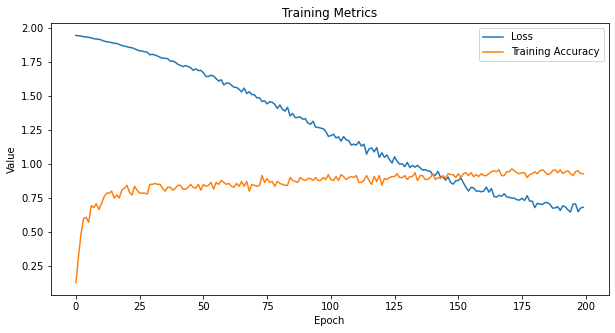

In [40]:
# Plot loss, training accuracy, and validation accuracy for all 200 epochs
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.plot(accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Metrics')
plt.legend()
plt.show()

# Model Evaluation

In [41]:
print("Final Evaluation on Test Set")
model.eval()
with torch.no_grad():
    test_out = model(data)
test_correct = compute_accuracy(test_out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
test_acc = int(test_correct) / int(data.test_mask.sum())
print(f'Accuracy on Test Set: {test_acc:.4f}')


Final Evaluation on Test Set
Accuracy on Test Set: 0.8110
